In [1]:
import numpy as np
import matplotlib.pyplot as plt

from cosmolisa import readdata
from cosmolisa.cosmology import CosmologicalParameters as cs
from cosmolisa.likelihood import find_redshift

import utilities as ut
# from read_EMRI import readEMRI

def zsquare(z):
    return z**2 / np.trapz(z**2, z)

def zcubic(z):
    return z**3 / np.trapz(z**3, z)

def zquartic(z):
    return z**4 / np.trapz(z**4, z)

def dvdz_true(z):
    dVdz = np.array([omega_true.ComovingVolumeElement(zi) for zi in z])
    return dVdz / np.trapz(dVdz, z)

def dvdz_true_normcosmo(z): #The same as dvdz_true, but using another function to compute the normalization
    dVdz = np.array([omega_true.ComovingVolumeElement(zi) for zi in z])
    return dVdz / omega_true.IntegrateComovingVolume(np.max(z))

def dvdz_cosmo1(z):
    dVdz = np.array([omega_cosmo1.ComovingVolumeElement(zi) for zi in z])
    return dVdz / np.trapz(dVdz, z)

truths = {
        'h': 0.673,
        'om': 0.315,
        'ol': 0.685,
        'w0': -1.0,
        'w1': 0.0,
        'Xi0': 1.0,
        'n1': 1.5,
        'b': 0.0,
        'n2': 1.0,
}

cosmo1 = truths.copy()
cosmo1['h'] = 0.66
cosmo1['om'] = 0.45
cosmo1['ol'] = 0.55

omega_true = cs(*truths.values())
omega_cosmo1 = cs(*cosmo1.values())


In [2]:
# Block to suppress function output
import contextlib
import io
f = io.StringIO()
##########################

# error boxes
data_path = "/Users/danny/Repos/cosmolisa_private/data/EMRI_MBHB_Project/My_realisations/EMRI_LEV_done_by_me/M1_AKS/3-sigma_zcut10_WKLS_SNR50/Error_boxes_LambdaCDM/Realisation_test_1"
snr = 50.0
with contextlib.redirect_stdout(f):
    events50 = readdata.read_dark_siren_event(
        data_path, 
        max_hosts=0,
        snr_threshold=snr,
        sigma_pv=0.0023,
        one_host_selection=0,
        z_gal_cosmo=0)

events80 = [ev for ev in events50.copy() if ev.snr >= 80.0]
events100 = [ev for ev in events50.copy() if ev.snr >= 100.0]


/Users/danny/mambaforge/envs/cosmolisa_nessai/lib/python3.9/site-packages/cosmolisa-0.0.0-py3.9-macosx-11.0-arm64.egg/cosmolisa/readdata.py:366: RuntimeWarning: invalid value encountered in true_divide
  sigma_gw_phi = np.mean((phi-best_phi)/dphi)
/Users/danny/mambaforge/envs/cosmolisa_nessai/lib/python3.9/site-packages/cosmolisa-0.0.0-py3.9-macosx-11.0-arm64.egg/cosmolisa/readdata.py:365: RuntimeWarning: invalid value encountered in true_divide
  sigma_gw_theta = np.mean((theta-best_theta)/dtheta)


In [3]:

z_errbox50 = np.array([event.z_true for event in events50])
z_errbox80 = np.array([event.z_true for event in events80])
z_errbox100 = np.array([event.z_true for event in events100])

zerrbox_max = {"50": max(z_errbox50), "80": max(z_errbox80), "100": max(z_errbox100)} 
zerrbox_min = {"50": min(z_errbox50), "80": min(z_errbox80), "100": min(z_errbox100)} 

zrange50 = np.linspace(zerrbox_min["50"], zerrbox_max["50"], 1000)
zrange80 = np.linspace(zerrbox_min["80"], zerrbox_max["80"], 1000)
zrange100 = np.linspace(zerrbox_min["100"], zerrbox_max["100"], 1000)

# full population
pop_path = "/Users/danny/Repos/cosmolisa_private/data/LISA_Collaborative_Project/M1_M7_M11_data/M1_all_EMRI.dat"
pop_data = np.genfromtxt(pop_path)

z = pop_data[:, 1]  # Full population

z_pop50 = np.array([zi for zi in z if zerrbox_min["50"] <= zi <= zerrbox_max["50"]])
z_pop80 = np.array([zi for zi in z if zerrbox_min["80"] <= zi <= zerrbox_max["80"]])
z_pop100 = np.array([zi for zi in z if zerrbox_min["100"] <= zi <= zerrbox_max["100"]])


In [ ]:
# Load galaxies up to the farthest redshift reached by error boxes z=1.0
path_lc = '/Users/danny/Repos/scope/Galaxy_catalog.hdf5'
lc = ut.read_galaxy_catalog(path_lc, z_max=1.0)

# Load light cone up to farthest detected EMRI (galaxies in the error boxes can go beyond that)
lc50 = ut.read_galaxy_catalog(path_lc, z_max=zerrbox_max["50"])
lc80 = ut.read_galaxy_catalog(path_lc, z_max=zerrbox_max["80"])
lc100 = ut.read_galaxy_catalog(path_lc, z_max=zerrbox_max["100"])

Reading the galaxy catalog...
...Done

Reading the galaxy catalog...
...Done

Reading the galaxy catalog...
...Done

Reading the galaxy catalog...
...Done



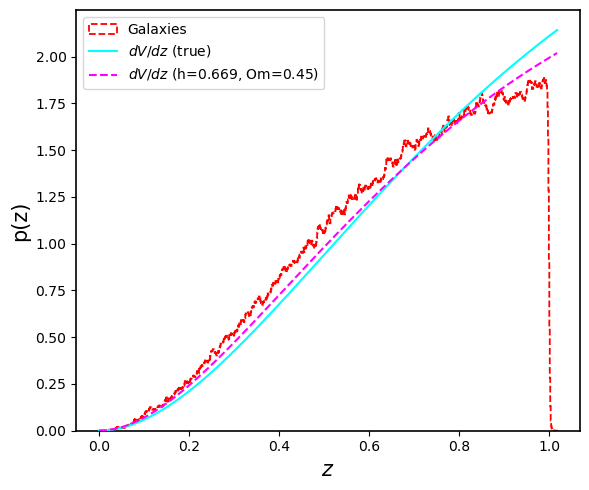

In [ ]:
# Show normalised dN/dz vs normalsied dV/dz
plt.figure(figsize=(6, 5))
zrange = np.linspace(np.min(lc["observed_redshift"]), np.max(lc["observed_redshift"]), 1000)
plt.hist(lc["observed_redshift"], bins=1000, histtype='step', linewidth=1.3, density=True, color="r", label="Galaxies", zorder=0, linestyle="--")
plt.plot(zrange, dvdz_true(zrange), color="cyan", label="$dV/dz$ (true)", zorder=7, linestyle="-")
plt.plot(zrange, dvdz_cosmo1(zrange), color="magenta", label="$dV/dz$ (h=0.669, Om=0.45)", zorder=8, linestyle="--")

plt.xlabel(r"$z$", fontsize=15)
plt.ylabel(r"p(z)", fontsize=15)
plt.tight_layout()
[plt.gca().spines[spine].set_linewidth(1.2) for spine in ['top', 'right', 'left', 'bottom']]
plt.legend(loc="upper left")
plt.show()

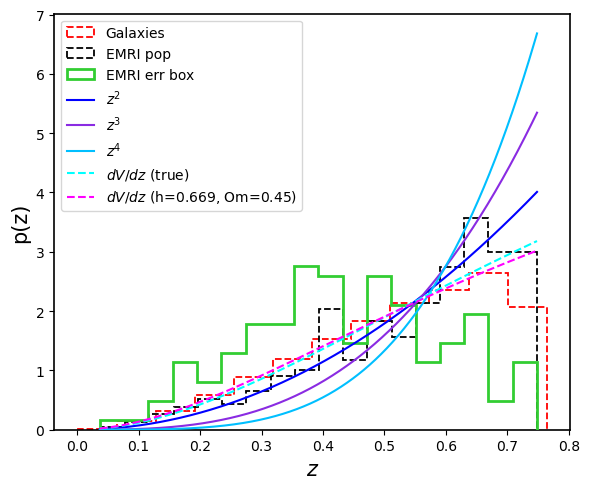

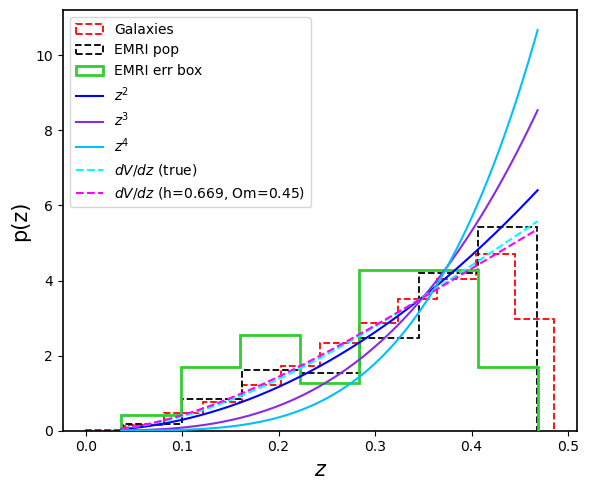

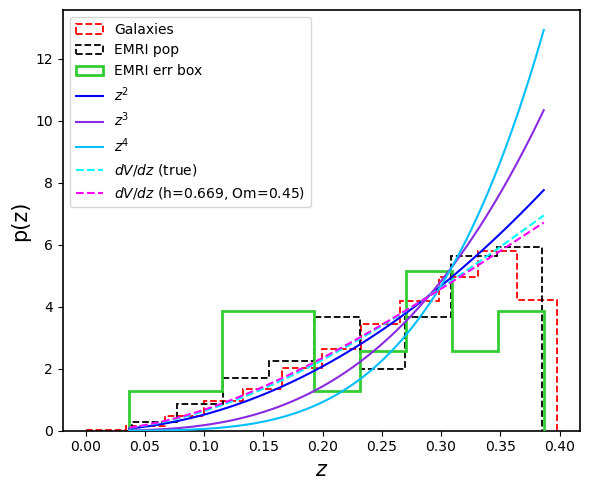

In [6]:
# Show galaxies up to the farthest EMRI used in the analysis (error boxes)
# The full EMRI population is equally shown, together with the detected population
# The "EMRI err box" is the data set used in the cosmological analysis for SNR>50,80,100
for lc, z_pop, z_errbox, zrange, bins in zip(
                        [lc50, lc80, lc100], 
                        [z_pop50, z_pop80, z_pop100],
                        [z_errbox50, z_errbox80, z_errbox100], 
                        [zrange50, zrange80, zrange100],
                        [18, 7, 9]):

    plt.figure(figsize=(6, 5))

    plt.hist(lc["observed_redshift"], bins=12, histtype='step', linewidth=1.3, density=True, color="r", label="Galaxies", zorder=0, linestyle="--")
    plt.hist(z_pop, bins=bins, histtype='step', linewidth=1.3, density=True, color="k", label="EMRI pop", zorder=1, linestyle="--")
    plt.hist(z_errbox, bins=bins, histtype='step', linewidth=2.0, density=True, color="limegreen", label="EMRI err box", zorder=3, linestyle="-")

    plt.plot(zrange, zsquare(zrange), color="blue", label="$z^2$", zorder=4)
    plt.plot(zrange, zcubic(zrange), color="blueviolet", label="$z^3$", zorder=5)
    plt.plot(zrange, zquartic(zrange), color="deepskyblue", label="$z^4$", zorder=6)
    plt.plot(zrange, dvdz_true(zrange), color="cyan", label="$dV/dz$ (true)", zorder=7, linestyle="--")
    plt.plot(zrange, dvdz_cosmo1(zrange), color="magenta", label="$dV/dz$ (h=0.669, Om=0.45)", zorder=8, linestyle="--")

    plt.xlabel(r"$z$", fontsize=15)
    plt.ylabel(r"p(z)", fontsize=15)
    plt.tight_layout()
    [plt.gca().spines[spine].set_linewidth(1.2) for spine in ['top', 'right', 'left', 'bottom']]
    plt.legend(loc="upper left")
    plt.show()